In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import os
import gc
import sys
import h5py
import pickle
import numpy as np
import itertools as it
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import sys, os
sys.path.append('./PDGNet')
import sysmodels as sysm
import utils #from utils import train, predict, initnw, weighted_selected_error_eval
from baselines import pa_orthog
from federated import *

# B = 180e3
# N0 = 1e-3 * 10**(-174/10)
# F = 10**(3/10)
# noise = B*N0*F
# noise

## load data

In [2]:

interf_scale = 1 # scale interference
i0 = 20 # which pmax

L = 8
n_ant = 10
M = 1
tr_dist = 'Alessio' # Alessio | HataSuburban | HataSuburban-noSF | HataUrban | HataUrban-noSF
te_dist = 'Alessio'

device = torch.device('cuda')

MODL_RT = "/root/wireless-fl-icassp/results/]archive/models-nr10-pdg/"
DATA_RT = "/root/wireless-fl/data/"

####################################################
####################   DATA   ######################
####################################################

B = 1
m = 0.023
pdb = np.array(range(-40,10+1,1))
indexing = np.delete(np.arange(L**2), np.arange(L**2)[::L+1])

# add initial pt (max)
attach_pt = lambda x: torch.from_numpy(np.hstack((utils.init_p(x[:,-1], L, method="full"), x))).float().to(device)

# move channel info to device
dict_to_device = lambda x,dev: {k:v.to(dev) if isinstance(v, torch.Tensor) else v for k, v in x.items()}

X, y, cinfo = {},{},{}
for phase in ['tr', 'val', 'test']:
    sufix = '' if phase=='tr' else phase+'-'
    dfn = DATA_RT + f"bs+{M}_ant+{n_ant}/{sufix}channels-{tr_dist}-{L}-1000.h5" # train / validation data
    X[phase],y[phase],cinfo[phase] = utils.load_data_unsup(dfn, hxp=False, num_stab=1e-12, PdB=pdb)
    
    X[phase] = attach_pt(X[phase])
    X[phase][:,L:-1][:,indexing]*=interf_scale 
    
    cinfo[phase] = dict_to_device(cinfo[phase], device)
    print(phase, X[phase].shape, y[phase].shape)


ph = 'test'
H_mat = X[ph][i0::len(pdb),L:-1].cpu().numpy().reshape(-1,L,L) #* noise
p_max = X[ph][i0::len(pdb),-1].cpu().numpy().reshape(-1)
h_all = np.vstack([np.diag(H) for H in H_mat])
beta_all = np.array(H_mat) 
for bi, b in enumerate(beta_all):
    for i in range(b.shape[0]):
        beta_all[bi, i, i]=0
        
curr_task = 'MNIST' # AirQuality | MNIST

tr torch.Size([51000, 73]) (51000, 8)
val torch.Size([51000, 73]) (51000, 8)
test torch.Size([51000, 73]) (51000, 8)


## for mnist classification

In [ ]:
from federated import *

dnum_sim = (np.random.RandomState(42).randint(100,1000,L )*5 ).astype(int)
k_weights = dnum_sim/dnum_sim.sum()

k_weights_noise = np.log(dnum_sim.max()/dnum_sim) +1
k_weights_noise = k_weights_noise/k_weights_noise.sum()

datanumber = dnum_sim

averagenumber = 10  # Number of implementation of FL
iteration     = 100  # Number of iterations for each FL implementation
iter_iters    = 5

numberofneuron = 50
in_size        = 784
out_size       = 10
msize = in_size*numberofneuron + numberofneuron*out_size + (numberofneuron+out_size) #=39760
Z = msize * 16 / 1024 / 1024    # Data size of each FL model, we assume that each element occupies 16 bits 
sysmodel = sysm.WirelessModel(bandwidth=B)

drequirement = Z / 0.7   ## delay requirement
erequirement = Z / 55    ## energy requirement

# MINST data processing
batch_size_train = 16
batch_size_test = 1000


##
inputdir_test = {
    'Hx_dir':{
        'Hx': X['test'][i0::51, :],
        'edge_index': cinfo['test']['edge_index']
    },
    'B':1, 
    'm':0.023
}

niid_type = 'dir' #{dir, gaus}

if niid_type == 'gaus':
    p_list = [500]#[0, 100, 500, 1000]
elif  niid_type == 'dir':
    p_list = [1]#, 0.75, 0.5]
else:
    raise

# # process local data: add noise to make it non-iid

NON_IID_ERR = {}
for p_niid in p_list:
    print(p_niid)
    # load datasets and manipulate noise
    train_set, test_set = utils.load_mnist('./datasets/', seed=None)#42)
    train_sets = []
    for user in range(L):
        d_indices = torch.arange(sum(datanumber[:user]), sum(datanumber[:user+1])) 
        train_sets.append(torch.utils.data.Subset(train_set, d_indices))
        
    # add noise
    if niid_type == 'gaus':
        train_sets = add_ni_noise(train_sets, datanumber, p_niid, k_weights_noise, seed=123)
    elif  niid_type == 'dir':
        train_datas, train_labels, statistic = data_partition_dir(
            train_set, datanumber, 10, alpha=p_niid, seed=123
        )
        for u in range(L):
            train_sets[u].dataset.data[train_sets[u].indices]    = train_datas[u]
            train_sets[u].dataset.targets[train_sets[u].indices] = train_labels[u]  

    inputs = {
        'channels': (h_all, beta_all, p_max),
        'fedtask' : (test_set, train_sets, batch_size_train),
        'require' : (drequirement, erequirement),
        'configs' : (numberofneuron, in_size, out_size), # fed network configs
    }

    FINAL_ERROR, GLOBAL_NET, NUM_SEL = {}, {}, {}
    
    ## ideal case and baselines
    for mkey in ['Ideal FL', 'Rand', 'Orth']:
        FINAL_ERROR[mkey], GLOBAL_NET[mkey], NUM_SEL[mkey] = FL_main(
            inputs        = inputs,
            fl_task       = curr_task, #'AirQuality', 'MNIST',
            allocation_scheme = mkey,
            usernumber    = L, 
            availnumber   = L,
            datanumber    = datanumber,
            kweights      = k_weights,
            iteration     = iteration, 
            iter_iters    = iter_iters,
            averagenumber = averagenumber,
            seed          = 0
        )
    
    ## MLP
    modeldir = './results2/models-nr10/Alessio_Ant+10_User+8_MLP_Intfx1_Pmax-20_Constr+c+7.00e-01_e+5.50e+01_LR+1.0e-04_seed+42/'
    finalq_mlp = per_from_learning_models(modeldir, L, inputdir_test)
    FINAL_ERROR['PDM'], _, NUM_SEL['PDM'] = FL_main(
        inputs        = inputs,
        fl_task       = curr_task,
        allocation_scheme = 'PD-MLP',
        usernumber    = L, 
        availnumber   = L,
        datanumber    = datanumber,
        kweights      = k_weights,
        iteration     = iteration, 
        iter_iters    = iter_iters,
        averagenumber = averagenumber,
        per_ready     = finalq_mlp,
        seed          = 0
    )


    ## GCN
    modeldir = './results2/models-nr10/Alessio_Ant+10_User+8_GCN_Intfx1_Pmax-20_Constr+c+7.00e-01_e+5.50e+01_LR+5.0e-04_seed+42/'
    finalq_gcn = per_from_learning_models(modeldir, L, inputdir_test)
    FINAL_ERROR['PDG'], _, NUM_SEL['PDG'] = FL_main(
        inputs        = inputs,
        fl_task       = curr_task,
        allocation_scheme = 'PD-GCN',
        usernumber    = L, 
        availnumber   = L,
        datanumber    = datanumber,
        kweights      = k_weights,
        iteration     = iteration, 
        iter_iters    = iter_iters,
        averagenumber = averagenumber,
        per_ready     = finalq_gcn,
        seed          = 0
    )
    
    NON_IID_ERR[p_niid] = FINAL_ERROR
    


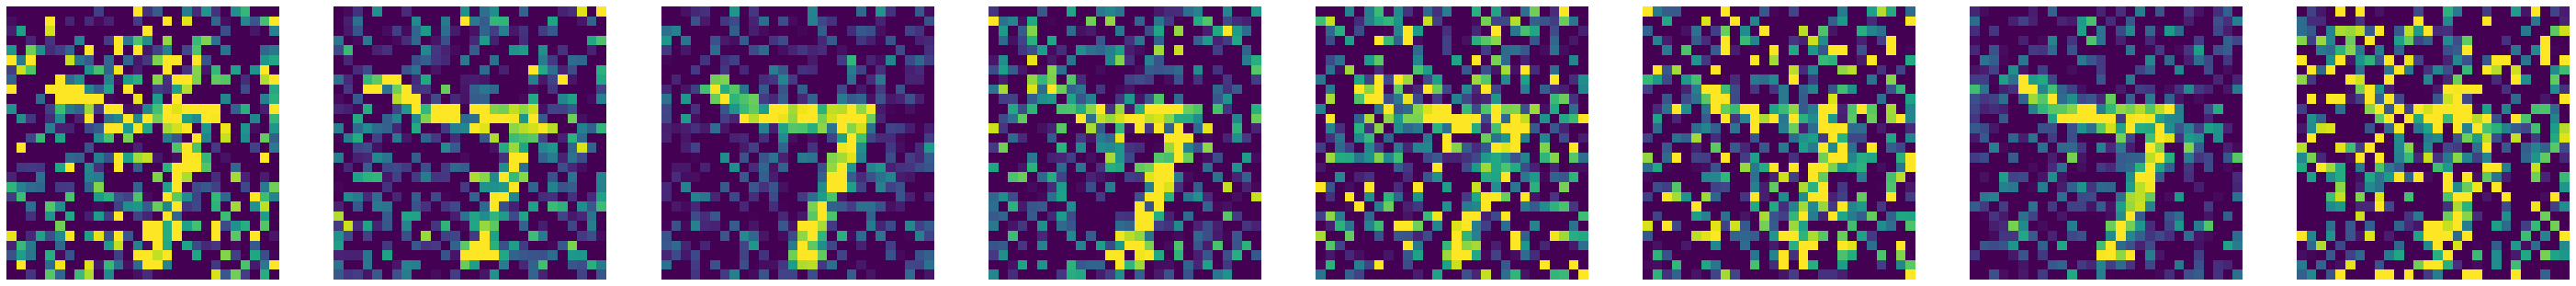

In [6]:
train_set, test_set = utils.load_mnist('./datasets/', seed=42)
oo = train_set.data[0]
fig, axes = plt.subplots(1,8,figsize=(50, 8))
for u in range(L):
    nn = 1000 *k_weights_noise[u]* torch.normal(0, 1, [28, 28])
    new = torch.clip(oo + nn, min=oo.min(), max=oo.max())
    plt.imshow(new)
    axes[u].imshow(new)
    axes[u].axis(False)

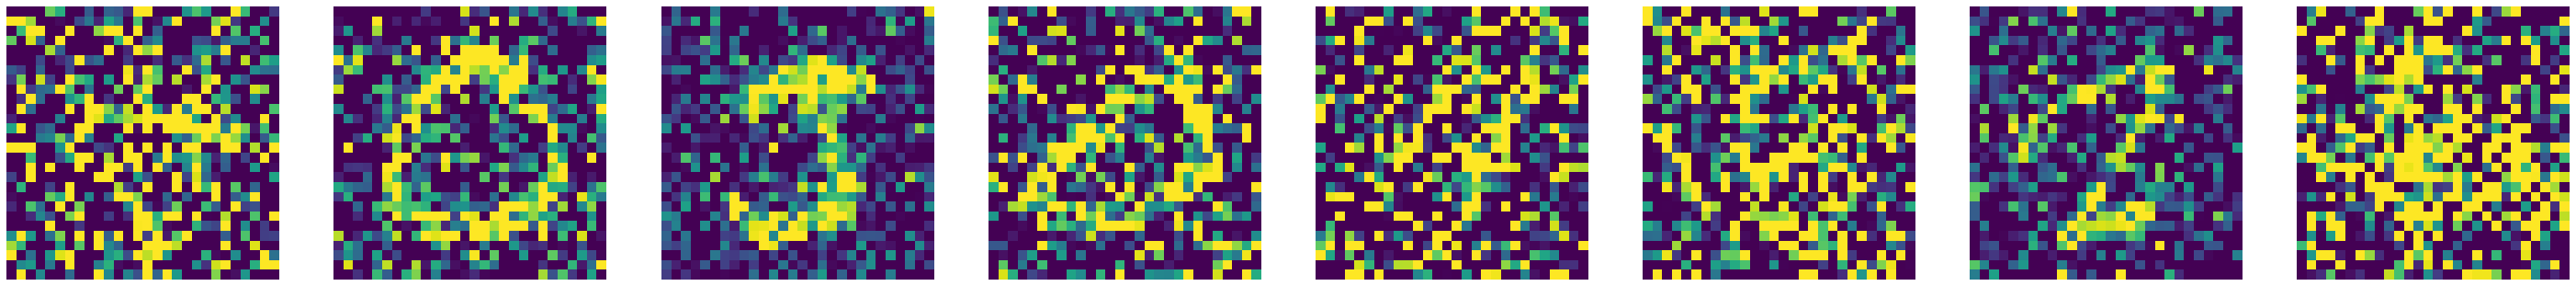

In [7]:
from federated import add_ni_noise
for non_iid_std in [1500]:
    # load datasets
    train_set, test_set = utils.load_mnist('./datasets/', seed=42)
    train_sets = []
    for user in range(L):
        d_indices = torch.arange(sum(datanumber[:user]), sum(datanumber[:user+1])) 
        train_sets.append(torch.utils.data.Subset(train_set, d_indices))
    train_sets = add_ni_noise(train_sets, datanumber, non_iid_std, k_weights_noise)


fig, axes = plt.subplots(1,8,figsize=(50, 8))
for u in range(L):
    axes[u].imshow(train_sets[u].dataset.data[train_sets[u].indices][0].numpy())
    axes[u].axis(False)

In [8]:
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("tab10"))

df_col = ['Rand', 'Orth', 'PDM', 'PDG', 'Ideal FL']
df = pd.DataFrame(NON_IID_ERR).applymap(lambda x: x.min(-1).mean())
df = df.reindex(df_col)
df_err = pd.DataFrame(NON_IID_ERR).applymap(lambda x: x.min(-1).std())
df_err = df_err.reindex(df.index.values)
df_t = df.iloc[:]

df_t.columns = ['Dirichlet']
df_t['Gaussian'] = df_t_gau
df_t = df_t[['Gaussian', 'Dirichlet']]

df_err.columns = ['Dirichlet']
df_err['Gaussian'] = df_gau_err
df_err = df_err[['Gaussian', 'Dirichlet']]
df_t

,Gaussian,Dirichlet
Rand,0.2156,0.3037
Orth,0.2516,0.3171
PDM,0.1945,0.2811
PDG,0.1610,0.1840
Ideal FL,0.1434,0.1526


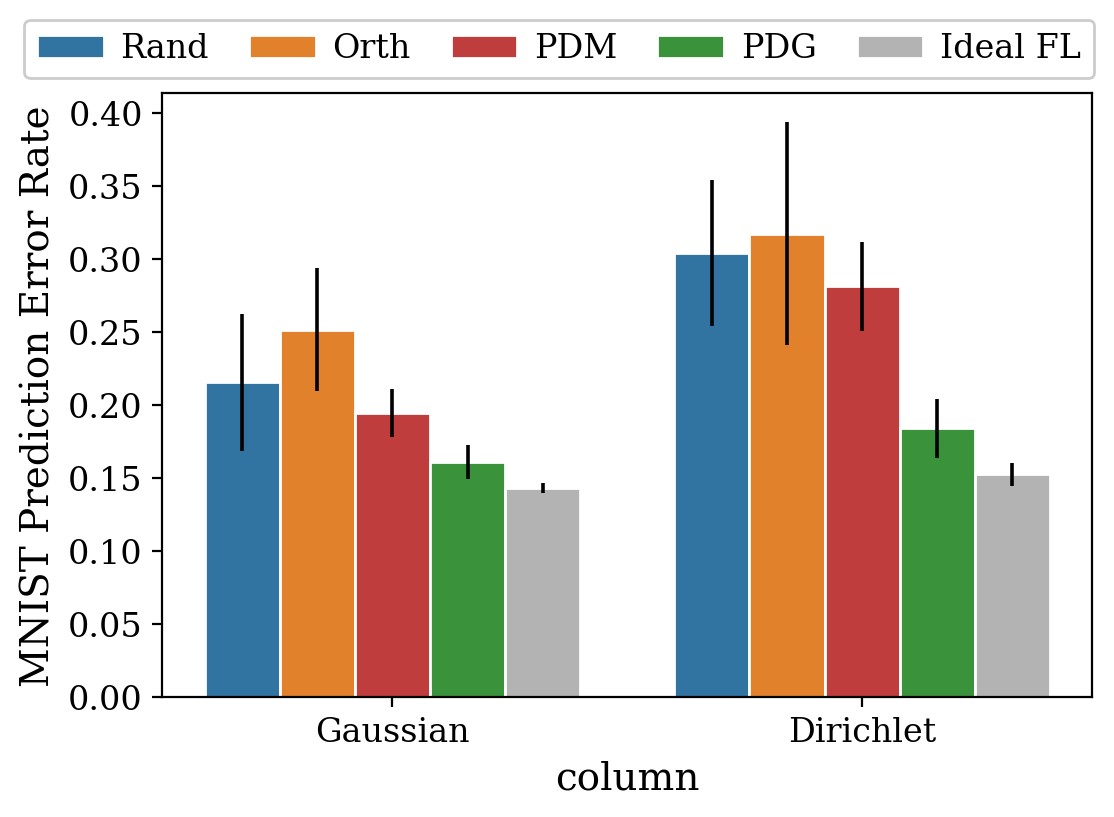

In [12]:

import matplotlib
import matplotlib.pyplot as plt
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
markercycle = it.cycle(('o','v','s','^','D','*','+','x')) 
linestycycle = ['-','--','-.',':']


dplot = pd.DataFrame({'Models': np.array([df_t.index.values.tolist()]*df_t.shape[1]).T.reshape(-1), 
              'column': list(df_t)*df_t.shape[0],
              'val': df_t.values.reshape(-1)
             })

cdict = dict(zip(dplot.Models[::df_t.shape[1]].values, colorcycle))
cdict['PDM'], cdict['PDG'] = cdict['PDG'], cdict['PDM']
cdict['Ideal FL'] = (0.7,0.7,0.7)

plt.figure(dpi=200)
ax = sns.barplot(data=dplot, x='column', y='val', hue='Models', palette=cdict, ec='w')
# ax.set_xlabel('Non-I.I.D. Base Noise STD')
ax.set_ylabel('MNIST Prediction Error Rate')
legend = plt.legend(title='', loc='best', ncol=5, columnspacing=1.2, 
                    handletextpad=0.5, bbox_to_anchor=(1.02,1.15))
legend.get_frame().set_alpha(None)

x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=df_err.iloc[:].values.reshape(-1), fmt="none", c= "k", lw=1.3)

# ax.set_ylim(.1,None)
ax.grid(False)


plt.savefig('non_iid_more.eps', format='eps')
plt.show()



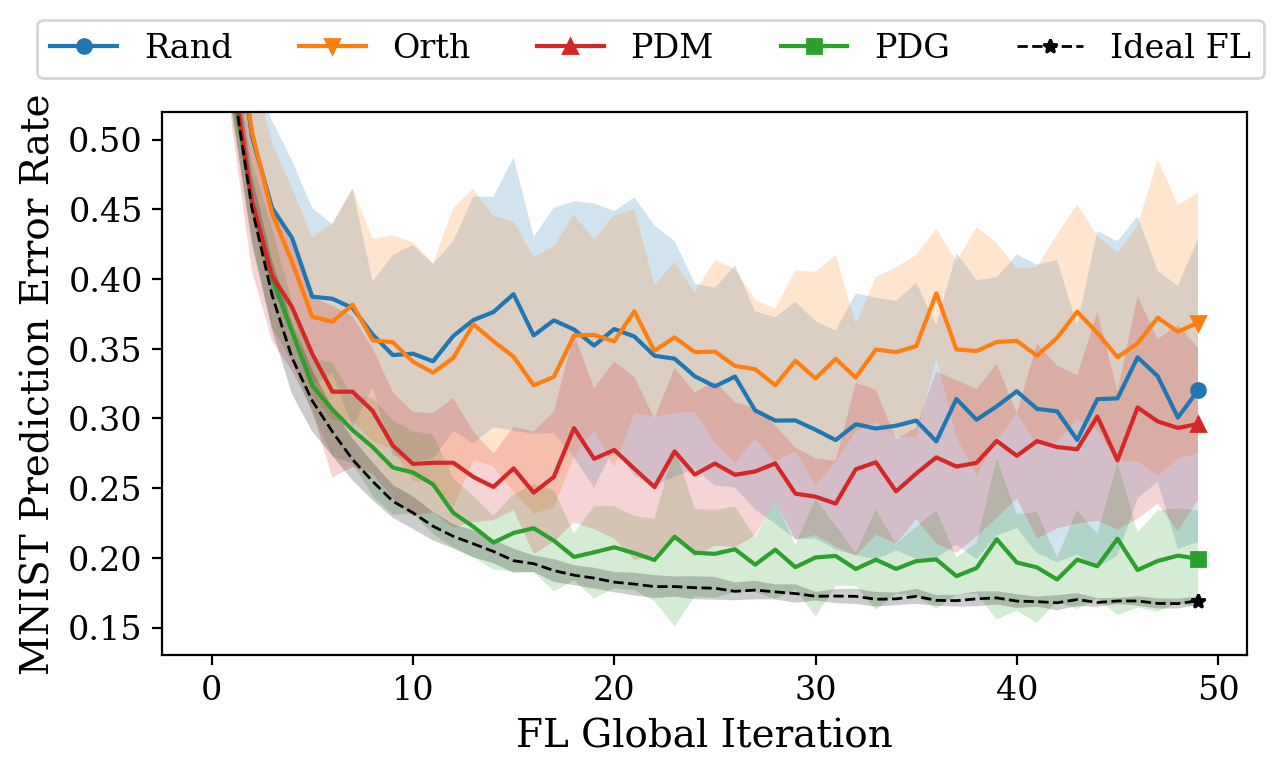

In [44]:
from copy import deepcopy
fin_err = deepcopy(FINAL_ERROR)
# fin_err = deepcopy(NON_IID_ERR_GAU[100])

[fin_err[k].sort(0) for k in fin_err.keys()]
if curr_task == 'MNIST':
    ylabel_string = 'MNIST Prediction Error Rate'
    max_scale = 1
    y_limits = None#[None, .36]#[.14, .36]
else:
    ylabel_string = 'Air Quality Prediction RMSE'
    max_scale = test_set.targets.max()
    y_limits = None#[None, 0.62]
ff = 10

pnames = ['Rand','Orth','PDG','PDM','Ideal FL']

fig, ax = plt.subplots(figsize=(7,4),dpi=200)
markercycle = it.cycle(('o','v','s','^','*','+','x')) 
for li, lab in enumerate(pnames):
    vals = fin_err[lab][:ff].mean(0)
    color = next(ax._get_lines.prop_cycler)['color']
    marker = next(markercycle)
    
    vv = vals[:50]/max_scale
    if li < len(pnames)-1:
        ax.plot(vv, markevery=[len(vv)-1], marker=marker, color=color, lw=1.5, label=lab)
    else:
        color = 'black'
        ax.plot(vv, ls='--', color=color, markevery=[len(vv)-1], marker=marker, lw=1, label=lab)
        
    # error shade
    ss = (FINAL_ERROR[lab][:ff]/max_scale).std(0)[:50]
    plt.fill_between(range(len(vv)), vv-ss, vv+ss, alpha=0.2, edgecolor='none', facecolor=color)

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(y_limits)
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))

ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%d"))

ax.set_xlabel('FL Global Iteration')
ax.set_ylabel(ylabel_string)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend()
handles, labels = ax.get_legend_handles_labels()
# labels = ['Rand','Orth','PDGNet','PDF','Ideal FL']
labels = pnames
ax.legend([handles[0], handles[1], handles[3], handles[2], handles[4]], 
          [labels[0], labels[1], labels[3], labels[2], labels[4]],
         loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=5)

plt.ylim([.13, .52])
plt.savefig('non_iid_dir_err_vs_ep.png', format='png')
plt.show()
